In [20]:
import json
import os
import pandas as pd
import matplotlib.pyplot as plt
import requests
import numpy as np
import datetime
import sys
import time
import nltk
import re

Открываю файл с регионами (curl -o areas.txt 'https://api.hh.ru/areas/113')

In [21]:
f = open('areas_json.txt')
areas = f.read()
f.close()
json_areas = json.loads(areas)

def region_print(place, list_of_areas, level):
    for i in place['areas']:
        list_of_areas.append([i['name'], int(i['id']), int(i['parent_id']), level])
        if i['areas']:
            region_print(i, list_of_areas, level + 1)

list_of_areas = []
list_of_areas.append([json_areas['name'], json_areas['id'], 0, 0])
region_print(json_areas, list_of_areas, 1)

table_area = pd.DataFrame(list_of_areas, columns = ['Name', 'Area_id', 'Parent_id', 'Level'])

In [22]:
print('Количетсво субъектов: ', table_area.shape[0])

Количетсво субъектов:  3852


В таблице представлено 3812 разных 'района'. И 84 регионов России.

In [23]:
table_area[table_area['Level'] == 1].head()

,Name,Area_id,Parent_id,Level
1,Республика Марий Эл,1620,113,1
23,Республика Татарстан,1624,113,1
83,Удмуртская Республика,1646,113,1
117,Чувашская Республика,1652,113,1
148,Забайкальский край,1192,113,1


Скачаю одну вакансию https://career.ru/vacancy/22157723

Автоматизируем

In [24]:
headers = {"User-Agent": "hh-recommender"}
r = requests.get("https://api.hh.ru/areas113", headers=headers)
areas_json = json.loads(r.text)

In [25]:
list_of_areas = []
list_of_areas.append([json_areas['name'], json_areas['id'], 0, 0])
region_print(json_areas, list_of_areas, 1)

In [26]:
table_area = pd.DataFrame(list_of_areas, columns = ['Name', 'Area_id', 'Parent_id', 'Level'])

In [27]:
table_area.head()

,Name,Area_id,Parent_id,Level
0,Россия,113,0,0
1,Республика Марий Эл,1620,113,1
2,Виловатово,4228,1620,2
3,Волжск,1621,1620,2
4,Звенигово,1622,1620,2


In [28]:
def find_all_vacancy_found(Area_id):
    r = requests.get("https://api.hh.ru/vacancies?per_page=5&specialization=1&specialization=25.381&specialization=3.26&specialization=3.48&specialization=9.94&specialization=12.5&specialization=12.92&specialization=15.93&specialization=14.91&specialization=17.112&area=" + str(Area_id), headers=headers)
    data_json = json.loads(r.text)
    return data_json['found']

def find_salary_vacancy_found(Area_id):
    r = requests.get("https://api.hh.ru/vacancies?per_page=5&specialization=1&specialization=25.381&specialization=3.26&specialization=3.48&specialization=9.94&specialization=12.5&specialization=12.92&specialization=15.93&specialization=14.91&specialization=17.112&only_with_salary=True&area=" + str(Area_id), headers=headers)
    data_json = json.loads(r.text)
    return data_json['found']

In [ ]:
table_area['Vacancies'] = table_area['Area_id'].apply(find_all_vacancy_found)
table_area['Vacancies_with_salary'] = table_area['Area_id'].apply(find_salary_vacancy_found)

In [29]:
table_area.to_csv('table_area.csv')

In [30]:
table_area = pd.read_csv('table_area.csv', index_col = 'Unnamed: 0')

Выделю таблицу по регионам России.

In [31]:
small_table_area = table_area[table_area['Level'] == 1] # 1 - уровень верхние регионы

In [32]:
small_table_area = pd.read_csv('table_area.csv', index_col = 'Unnamed: 0')

Добавлю количество вакансий с зарплатой и без.

In [34]:
small_table_area['Vacancies'] = small_table_area['Area_id'].apply(find_all_vacancy_found)
small_table_area['Vacancies_with_salary'] = small_table_area['Area_id'].apply(find_salary_vacancy_found)

KeyboardInterrupt: 

In [33]:
small_table_area.sort_values(by='Vacancies_with_salary', ascending=False).head(10)

KeyError: 'Vacancies_with_salary'

Экспортирую таблицу в экселевский файл

In [23]:
small_table_area[['Name','Vacancies','Vacancies_with_salary']].to_excel('small_table_area_140117.xlsx',index=False)
small_table_area[['Name','Vacancies','Vacancies_with_salary']].to_csv('small_table_area_140117.csv',index=False)

In [ ]:
small_table_area[['Name','Vacancies','Vacancies_with_salary']].to_excel('small_table_area.xlsx',index=False)

In [18]:
small_table_area.sort_values(by = 'Vacancies_with_salary', ascending = False)[['Name', 'Vacancies_with_salary']].head()

,Name,Vacancies_with_salary
906,Москва,8347
1613,Санкт-Петербург,3459
23,Республика Татарстан,957
764,Новосибирская область,918
2178,Свердловская область,836


In [35]:
%matplotlib inline

top_15_areas = small_table_area.sort_values(by = 'Vacancies_with_salary', ascending = False)['Name'][0:15].values
top_15_areas_amount = small_table_area.sort_values(by = 'Vacancies_with_salary', ascending = False)['Vacancies_with_salary'][0:15].values
y_pos = np.arange(len(top_15_areas))
plt.figure()
plt.barh(y_pos, top_15_areas_amount,align='center', alpha=0.5)
plt.yticks(y_pos, top_15_areas)
plt.xlabel('Количество вакансий')
plt.title('Топ 15 регионов')
plt.show()

KeyError: 'Vacancies_with_salary'

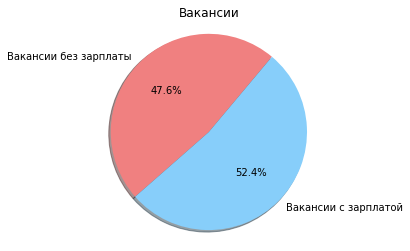

In [25]:
plt.figure()

labels = ['Вакансии без зарплаты', 'Вакансии с зарплатой']
sizes = [small_table_area['Vacancies'].sum() - small_table_area['Vacancies_with_salary'].sum(), small_table_area['Vacancies_with_salary'].sum()]
colors = ['lightcoral', 'lightskyblue']

plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=50)
plt.title('Вакансии')
plt.axis('equal')
plt.show()

In [10]:
r = requests.get("https://api.hh.ru/vacancies?per_page=5&area=1&specialization=1&specialization=25.381&specialization=3.26&specialization=3.48&specialization=9.94&specialization=12.5&specialization=12.92&specialization=15.93&specialization=14.91&specialization=17.112", headers=headers)
test_json = json.loads(r.text)

Массив вакансий, для создания дата фрэйма потом

Функция поиска текущих id вакансий.

In [56]:
last_update = str(datetime.date(2017, 9, 10))

заебался

In [26]:
today = str( (datetime.datetime.today() - datetime.timedelta(days=1)).date()) 

In [27]:
def find_new_vacanacies(date_from, date_to, area_id, num_page=0):
    start = 'https://api.hh.ru/vacancies?per_page=100' + '&only_with_salary=True'
    spec_it = '&specialization=1&specialization=25.381&specialization=3.26&specialization=3.48&specialization=9.94&specialization=12.5&specialization=12.92&specialization=15.93&specialization=14.91&specialization=17.112'
    area = '&area=' + str(area_id)
    dfrom = '&date_from=' + date_from
    dto = '&date_to=' + date_to
    page = '&page=' + str(num_page)
    r = requests.get(start + spec_it + area + dfrom + dto + page, headers=headers)
    r_json = json.loads(r.text)
    return r_json

In [28]:
def middle_day(last_update, today):
    year_today, month_today, day_today = map(int, today.split('-'))
    year_last, month_las, day_last = map(int, last_update.split('-')) 
    dif = datetime.date(year_today, month_today, day_today) - datetime.date(year_last, month_las, day_last)
    dif = datetime.timedelta(days= (dif/2).days)
    mid_day = dif + datetime.date(year_last, month_las, day_last)
    return str(mid_day)

In [29]:
def find_id_in_json(json_items, new_vac_id):
    for item in json_items:
        new_vac_id.add(item['id'])
    return 0

In [30]:
def update_area_vacancy(last_update, today, area, new_vac_id):
    limit_views = 2000
    first_area_json = find_new_vacanacies(last_update, today, area) #стартовая страница для субъекта
    if first_area_json['found'] >= limit_views: #hh не позволяет скачать больше, сделать проверку вдруг это изменится
        mid_day = middle_day(last_update, today)
        if mid_day != last_update:
            update_area_vacancy(last_update, mid_day, area, new_vac_id)
            update_area_vacancy(mid_day, today, area, new_vac_id)
            return 0
        else:
            update_area_vacancy(last_update, mid_day, area, new_vac_id)
            update_area_vacancy(today, today, area, new_vac_id)
            return 0
    find_id_in_json(first_area_json['items'], new_vac_id)
    for num_page in range(1, first_area_json['pages']):
        vac_area_json = find_new_vacanacies(last_update, today, area, num_page) #стартовая страница для субъекта
        find_id_in_json(vac_area_json['items'], new_vac_id)
    return 0

In [31]:
def update_table(vacancies, small_table_area, last_update, today):
    all_new_vac_id = {}
    len_area = small_table_area.shape[0]
    i = 0
    for area_id in small_table_area['Area_id']: # пробегает по всем субъектам
        print( round(100*i/len_area, 1), end = '% ')
        i += 1
        all_new_vac_id[area_id] = set()
        update_area_vacancy(last_update, today, area_id, all_new_vac_id[area_id])
        all_new_vac_id[area_id] = list(all_new_vac_id[area_id])
    return all_new_vac_id

In [205]:
r_json = find_new_vacanacies('2017-09-11', '2017-10-12', 1) # первый пробник 13 октября

In [33]:
r_json = find_new_vacanacies('2017-10-12', today, 1) # второй пробник 14 ноября, не нужно, проверка

In [35]:
#второй пробник 14 ноября
vacancies = []#id, area_id, name, salary_from, salary_to, salary_cur, data, url, experience, company_name, company_id description, employment, schedule, key_skills, specialisation, arhived 
all_new_vac_id = update_table(vacancies, small_table_area.sort_values(by = 'Vacancies_with_salary', ascending = False), '2017-10-12', today)

0.0% 1.2% 2.4% 3.6% 4.8% 6.0% 7.1% 8.3% 9.5% 10.7% 11.9% 13.1% 14.3% 15.5% 16.7% 17.9% 19.0% 20.2% 21.4% 22.6% 23.8% 25.0% 26.2% 27.4% 28.6% 29.8% 31.0% 32.1% 33.3% 34.5% 35.7% 36.9% 38.1% 39.3% 40.5% 41.7% 42.9% 44.0% 45.2% 46.4% 47.6% 48.8% 50.0% 51.2% 52.4% 53.6% 54.8% 56.0% 57.1% 58.3% 59.5% 60.7% 61.9% 63.1% 64.3% 65.5% 66.7% 67.9% 69.0% 70.2% 71.4% 72.6% 73.8% 75.0% 76.2% 77.4% 78.6% 79.8% 81.0% 82.1% 83.3% 84.5% 85.7% 86.9% 88.1% 89.3% 90.5% 91.7% 92.9% 94.0% 95.2% 96.4% 97.6% 98.8% 

In [207]:
all_new_vac_id = update_table(vacancies, small_table_area.sort_values(by = 'Vacancies_with_salary', ascending = False), '2017-09-11', '2017-10-12')

0.0% 1.2% 2.4% 3.6% 4.8% 6.0% 7.1% 8.3% 9.5% 10.7% 11.9% 13.1% 14.3% 15.5% 16.7% 17.9% 19.0% 20.2% 21.4% 22.6% 23.8% 25.0% 26.2% 27.4% 28.6% 29.8% 31.0% 32.1% 33.3% 34.5% 35.7% 36.9% 38.1% 39.3% 40.5% 41.7% 42.9% 44.0% 45.2% 46.4% 47.6% 48.8% 50.0% 51.2% 52.4% 53.6% 54.8% 56.0% 57.1% 58.3% 59.5% 60.7% 61.9% 63.1% 64.3% 65.5% 66.7% 67.9% 69.0% 70.2% 71.4% 72.6% 73.8% 75.0% 76.2% 77.4% 78.6% 79.8% 81.0% 82.1% 83.3% 84.5% 85.7% 86.9% 88.1% 89.3% 90.5% 91.7% 92.9% 94.0% 95.2% 96.4% 97.6% 98.8% 

In [36]:
def get_vacancy(vac_id):
    r_vac = requests.get('https://api.hh.ru/vacancies/' + str(vac_id), headers=headers)
    vac_json = json.loads(r_vac.text)
    return vac_json

In [37]:
def description_filter(text):
    while True:
        left = text.find('<')
        right = text.find('>')
        if left != -1 and right != -1:
            text = text[:left] + text[right + 1:]
        else:
            return text
    return 0

In [38]:
def key_skills_get(key_skills):
    answer_skills = []
    if key_skills:
        for skills in key_skills:
            answer_skills.append(skills['name'])
    return answer_skills

In [39]:
def specializations_get(specializations):
    answer_specializations = []
    for spec in specializations:
        answer_specializations.append(spec['id'])
    return answer_specializations

In [40]:
def check_key_in_dict(key, _dict):
    return key in _dict

In [41]:
def check_add_info_from_json(key, _dict, fail_value='nan'):
    if check_key_in_dict(key, _dict):
        return _dict[key]
    else:
        return fail_value
    return 0

In [42]:
def resume_analysis(vac_json): #Анализ скаченного резюме
    vac = [] # cоздание листа с данными
    vac.append(vac_json['name']) #имя вакансии
    vac.append(check_add_info_from_json('from', vac_json['salary']))
    vac.append(check_add_info_from_json('to', vac_json['salary']))
    vac.append(check_add_info_from_json('currency', vac_json['salary'], 'RUR'))
    vac.append(vac_json['published_at'][0:10])
    vac.append(vac_json['alternate_url'])
    vac.append(check_add_info_from_json('id', vac_json['experience']))
    vac.append(check_add_info_from_json('name', vac_json['employer']))
    vac.append(check_add_info_from_json('id', vac_json['employer']))
    vac_description = description_filter(vac_json['description'])
    vac.append(vac_description)
    vac.append(check_add_info_from_json('name', vac_json['employment']))
    vac.append(check_add_info_from_json('name', vac_json['schedule']))
    vac.append(key_skills_get(vac_json['key_skills']))
    vac.append(specializations_get(vac_json['specializations']))
    vac.append(vac_json['archived'])
    return vac

In [8]:
vacancies = []#id, area_id, name, salary_from, salary_to, salary_cur, data, url, experience, company_name, company_id description, employment, schedule, key_skills, specialisation, arhived 

In [52]:
def take_vacancies(all_new_vac_id, vacancies = [], ignore_vac = [], bad_vac = 0, abort = 0):
    vacancies = vacancies
    try:
        amount = 0
        for area in all_new_vac_id:
            for new_id in all_new_vac_id[area]:
                amount+= 1
                if amount % 1000 == 0:
                    print(amount, end=' ')
                    time.sleep(2)
                if str(new_id) in ignore_vac:
                    continue
                new_vacancy = [new_id, area]
                ignore_vac.append(str(new_id))
                try:
                    vac_json = get_vacancy(new_id)
                except ConnectionError:
                    print('Слишком много запросов при обновлении.')
                    abort += 1
                    time.sleep(5)
                    if abort == 6:
                        return vacancies
                    continue
                try:
                    new_vacancy.extend(resume_analysis(vac_json))
                    vacancies.append(new_vacancy)
                except:
                    bad_vac += 1
                    vacancies.append(new_vacancy)
        return vacancies
    except:
        print('Неизвестная ошибка')
        abort += 1
        time.sleep(5)
        if abort == 6:
            return vacancies
        print(sys.exc_info())
        #vacancies = take_vacancies(all_new_vac_id, vacancies, vacancies, 0, abort)
        return vacancies
    return vacancies

In [54]:
vacancies = take_vacancies(all_new_vac_id, vacancies, list(table_vacancies141117['Id'].values))

1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 13000 14000 15000 16000 17000 18000 19000 20000 21000 22000 23000 24000 25000 26000 

In [14]:
# не помню зачем
r_professional_areas = requests.get('https://api.hh.ru/salary_statistics/dictionaries/professional_areas', headers=headers)
professional_areas = json.loads(r_professional_areas.text)

In [55]:
table_vacancies141117 = pd.DataFrame(vacancies, columns = ['Id', 'Area_id', 'Name', 'Salary_from', 'Salary_to',
                                                     'Salary_cur', 'Data', 'Url', 'Experience', 'Company_name',
                                                     'Company_id', 'Description', 'Employment', 'Schedule',
                                                     'Key_skills', 'Specialisation', 'Arhived' ])

In [47]:
#первый заход 13 октября
table_vacancies = pd.DataFrame(vacancies, columns = ['Id', 'Area_id', 'Name', 'Salary_from', 'Salary_to',
                                                     'Salary_cur', 'Data', 'Url', 'Experience', 'Company_name',
                                                     'Company_id', 'Description', 'Employment', 'Schedule',
                                                     'Key_skills', 'Specialisation', 'Arhived' ])

vacancies = take_vacancies(all_new_vac_id, vacancies, list(table_vacancies['Id'].values))

table_vacancies = pd.DataFrame(vacancies, columns = ['Id', 'Area_id', 'Name', 'Salary_from', 'Salary_to',
                                                     'Salary_cur', 'Data', 'Url', 'Experience', 'Company_name',
                                                     'Company_id', 'Description', 'Employment', 'Schedule',
                                                     'Key_skills', 'Specialisation', 'Arhived' ])

In [241]:
table_vacancies.to_csv('table_vacancies.csv')

In [ ]:
#второй заход 14 ноября
table_vacancies141117 = pd.DataFrame(vacancies, columns = ['Id', 'Area_id', 'Name', 'Salary_from', 'Salary_to',
                                                     'Salary_cur', 'Data', 'Url', 'Experience', 'Company_name',
                                                     'Company_id', 'Description', 'Employment', 'Schedule',
                                                     'Key_skills', 'Specialisation', 'Arhived' ])
vacancies = take_vacancies(all_new_vac_id, vacancies, list(table_vacancies141117['Id'].values))#работает долго

In [56]:
#второй заход 14 ноября
table_vacancies141117 = pd.DataFrame(vacancies, columns = ['Id', 'Area_id', 'Name', 'Salary_from', 'Salary_to',
                                                     'Salary_cur', 'Data', 'Url', 'Experience', 'Company_name',
                                                     'Company_id', 'Description', 'Employment', 'Schedule',
                                                     'Key_skills', 'Specialisation', 'Arhived' ])
table_vacancies141117.to_csv('table_vacancies141117.csv')

In [4]:
table_vacancies = pd.read_csv('table_vacancies.csv', index_col = 'Unnamed: 0')
#table_vacancies = table_vacancies.rename(columns={'name' : 'Name'})

In [5]:
def experience_exp(Experience):
    if Experience == 'moreThan6':
        return 'senior'
    elif Experience == 'between3And6':
        return 'senior'
    elif Experience == 'between1And3':
        return 'middle'
    elif Experience == 'noExperience':
        return 'junior'
    return None


def experience_name(Name):
    text = Name.lower()
    sen_exp = ['senior', 'главный', 'ведущий', 'сеньор']
    mid_exp = ['middle', 'мидл', 'developer',]
    jun_exp = ['junior', 'младший', 'стажер', 'джуниор']
    for word in jun_exp:
        if text.find(word) + 1:
            return 'junior'
    for word in mid_exp:
        if text.find(word) + 1:
            return 'middle'
    for word in sen_exp:
        if text.find(word) + 1:
            return 'senior'
    return None



In [19]:
qualification_exp = table_vacancies['Experience'].apply(experience_exp)#первый анализ
qualification_name = table_vacancies['Name'].apply(experience_name)

In [71]:
table_vacancies141117.drop(21523, axis=0, inplace=True) #удаляю нулевые значения

In [73]:
qualification_exp141117 = table_vacancies141117['Experience'].apply(experience_exp)#второй анализ
qualification_name141117 = table_vacancies141117['Name'].apply(experience_name)

In [20]:
table_vacancies['qualification'] = qualification_name#первый анализ
table_vacancies['qualification'] = table_vacancies['qualification'].combine_first(qualification_exp)

In [74]:
table_vacancies141117['qualification'] = qualification_name141117#второй анализ
table_vacancies141117['qualification'] = table_vacancies141117['qualification'].combine_first(qualification_exp141117)

In [29]:
#бля 

In [3]:
table_vacancies141117['qualification'].value_counts()

NameError: name 'table_vacancies141117' is not defined

In [76]:
table_vacancies['qualification'].value_counts()

middle    14118
junior     6682
senior     6054
Name: qualification, dtype: int64

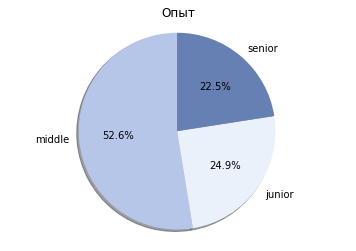

In [128]:
plt.figure() #первый анализ октября -сентябрь

labels = table_vacancies['qualification'].value_counts().index.tolist()
sizes = table_vacancies['qualification'].value_counts().values.tolist()
colors = ['#b5c6e8', '#ebf1fb', '#6780b3']

plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('Опыт')
plt.axis('equal')
plt.show()

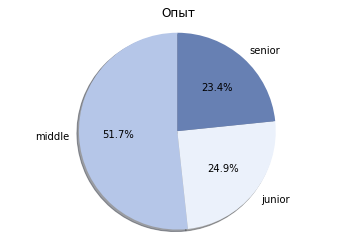

In [181]:
plt.figure() #второй анализ ноябрь-октябрь

labels = table_vacancies141117['qualification'].value_counts().index.tolist()
sizes = table_vacancies141117['qualification'].value_counts().values.tolist()
colors = ['#b5c6e8', '#ebf1fb', '#6780b3']
explode = (0, 0, 0)  # explode slice

plt.rcParams.update({'font.size': 10})
plt.pie(sizes, labels=labels, explode=explode, colors=colors, autopct='%1.1f%%', shadow=True, startangle=90)

plt.title('Опыт')
plt.axis('equal')
plt.show()

In [7]:
def find_word(Description, words = search_words[language]):
    text = Description.lower()
    for word in words:
        if text.find(word) + 1:
            return 1
    return None

def find_word_name(Name, words = search_words[language]):
    text = Name.lower()
    for word in words:
        if text.find(word) + 1:
            return 1
    return None

def hard_find_word(Description, word = 'java'):
    s = Description
    for bad_word in ['javascript', 'java-script', '-', '(', ')']:
        s = s.replace(bad_word, ' ')
    prog = re.compile('[А-Яа-яA-Za-z\-]+')
    l1 = prog.findall(s.lower())
    d1 = nltk.FreqDist(l1)
    if bool(d1[word]):
        return 1
    return None


In [6]:
search_words = {'Python' : ['питон', 'python'], 'C++': ['c++', ' си ', 'с++', '(си)'],
                'PHP': ['php', 'пхп'], 'C#': ['c#', 'с#'], 'SQL':['sql'], 'HTML': ['html'],
                'CSS': ['css'], 'Javascript': [' js', 'javascript', 'java-script'],
                'Swift': ['swift', 'свифт'], 'Ruby': ['ruby'], 'Postgres': ['postgres', 'постгрес'],
                'IOS': ['ios'], 'Android': ['android'],
                'Go': ['golang', '/go', ' go,', ' go.', '(go)', ' go-', ' go разработ⁢чик', 'на go '],
                'Oracle': ['oracle']}
languages = ['Python', 'C++', 'PHP', 'C#', 'SQL', 'HTML', 'CSS', 'Javascript',
             'Swift', 'Ruby', 'Postgres', 'IOS', 'Android', 'Go', 'Oracle']
language = 'Python'

In [10]:
Java = table_vacancies141117['Description'].apply(hard_find_word)

In [11]:
Java_name = table_vacancies141117['Name'].apply(hard_find_word)

In [12]:
table_vacancies141117['Java'] = Java
table_vacancies141117['Java_name'] = Java_name

In [110]:
for i in range(len(languages)):# второй заход
    language = languages[i]
    def find_word(Description, words = search_words[language]):
        text = Description.lower()
        for word in words:
            if text.find(word) + 1:
                return 1
        return None

    def find_word_name(Name, words = search_words[language]):
        text = Name.lower()
        for word in words:
            if text.find(word) + 1:
                return 1
        return None

    table_vacancies141117[languages[i]] = table_vacancies141117['Description'].apply(find_word)
    table_vacancies141117[languages[i] + '_name'] = table_vacancies141117['Name'].apply(find_word_name)

In [14]:
table_vacancies141117.to_csv('table_vacancies141117.csv')

In [116]:
table_vacancies141117 = pd.read_csv('table_vacancies141117.csv', index_col = 'Unnamed: 0')

In [117]:
table_vacancies141117.head()

,Id,Area_id,Name,Salary_from,Salary_to,Salary_cur,Data,Url,Experience,Company_name,...,IOS,IOS_name,Android,Android_name,Go,Go_name,Oracle,Oracle_name,Java,Java_name
0,23233819,1,"Руководитель группы продаж (digital, интернет-...",80000.0,NaN,RUR,2017-10-25,https://hh.ru/vacancy/23233819,between1And3,"Элемент, РА",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,23408155,1,Тестировщик (QA),NaN,60000.0,RUR,2017-11-09,https://career.ru/vacancy/23408155,between1And3,Performance Lab (Перфоманс Лаб),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
2,22724239,1,Web-программист/HTML-верстальщик,NaN,120000.0,RUR,2017-11-10,https://hh.ru/vacancy/22724239,between1And3,DigitalHR,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,23103201,1,Ведущий менеджер по продажам,60000.0,150000.0,RUR,2017-11-12,https://hh.ru/vacancy/23103201,between1And3,е.Ком,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,23202651,1,Директор по маркетингу (Университет),250000.0,NaN,RUR,2017-10-23,https://hh.ru/vacancy/23202651,moreThan6,Университет Туро,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [53]:
areas_bot = {'Москва': 1,
             'Санкт-Петербург': 2,
             'Казань': 1624,
             #'Иннополис': 2734,
             'Нижний Новгород': 1679,
             'Новосибирск': 1202,
             'Воронеж': 1844,
             'Самара': 1586,
             'Екатеринбург': 1261,
             'Томск': 1255,
             'Рязань': 1704,
             'Уфа': 1347,
             'Красноярск': 1146}

In [54]:
levels_bot = {'Junior': 'junior',
              'Middle': 'middle',
              'Senior': 'senior'}

In [50]:
abilities_bot = ['Java', 'Javascript', 'Python', 'C++', 'C#', 'IOS', 'Android',
                 'PHP', 'Go', 'Ruby', 'SQL', 'Oracle', 'Postgres', 'HTML', 'CSS']

## Полная таблица вакансий

In [129]:
info_all = []#area, level, ability, mean_from, min_from, max_from, median_from, standard deviation_from
#mean_to, min_to, max_to, median_to, standard deviation_to
#mean, min, max, median, standart deviation

In [130]:
num = 0
for name_area in areas_bot:
    area = areas_bot[name_area]
    print(str(round(num/13*100, 2)) +  '%', end=' ')
    num += 1
    for abil in abilities_bot:
        for in_name in ['']:
            ability = abil + in_name
            for lev in levels_bot:
                level = levels_bot[lev]
                answer = [name_area, ability, level]
                answer_from_mean = table_vacancies141117[((table_vacancies141117[ability] == 1) 
                    & (table_vacancies141117['Area_id'] == area)
                    & (table_vacancies141117['Salary_cur'] == 'RUR')
                    & (table_vacancies141117['qualification'] == level)
                    & (table_vacancies141117['Salary_from']))]['Salary_from'].mean()
                answer_from_min = table_vacancies141117[((table_vacancies141117[ability] == 1) 
                    & (table_vacancies141117['Area_id'] == area)
                    & (table_vacancies141117['Salary_cur'] == 'RUR')
                    & (table_vacancies141117['qualification'] == level)
                    & (table_vacancies141117['Salary_from']))]['Salary_from'].min()
                answer_from_max = table_vacancies141117[((table_vacancies141117[ability] == 1) 
                    & (table_vacancies141117['Area_id'] == area)
                    & (table_vacancies141117['Salary_cur'] == 'RUR')
                    & (table_vacancies141117['qualification'] == level))]['Salary_from'].max()
                answer_from_median = table_vacancies141117[((table_vacancies141117[ability] == 1) 
                    & (table_vacancies141117['Area_id'] == area)
                    & (table_vacancies141117['Salary_cur'] == 'RUR')
                    & (table_vacancies141117['qualification'] == level))]['Salary_from'].median()
                answer_from_std = table_vacancies141117[((table_vacancies141117[ability] == 1) 
                    & (table_vacancies141117['Area_id'] == area)
                    & (table_vacancies141117['Salary_cur'] == 'RUR')
                    & (table_vacancies141117['qualification'] == level))]['Salary_from'].std()

                answer_to_mean = table_vacancies141117[((table_vacancies141117[ability] == 1) 
                    & (table_vacancies141117['Area_id'] == area)
                    & (table_vacancies141117['Salary_cur'] == 'RUR')
                    & (table_vacancies141117['qualification'] == level))]['Salary_to'].mean()
                answer_to_min = table_vacancies141117[((table_vacancies141117[ability] == 1) 
                    & (table_vacancies141117['Area_id'] == area)
                    & (table_vacancies141117['Salary_cur'] == 'RUR')
                    & (table_vacancies141117['qualification'] == level))]['Salary_to'].min()
                answer_to_max = table_vacancies141117[((table_vacancies141117[ability] == 1) 
                    & (table_vacancies141117['Area_id'] == area)
                    & (table_vacancies141117['Salary_cur'] == 'RUR')
                    & (table_vacancies141117['qualification'] == level))]['Salary_to'].max()
                answer_to_median = table_vacancies141117[((table_vacancies141117[ability] == 1) 
                    & (table_vacancies141117['Area_id'] == area)
                    & (table_vacancies141117['Salary_cur'] == 'RUR')
                    & (table_vacancies141117['qualification'] == level))]['Salary_to'].median()
                answer_to_std = table_vacancies141117[((table_vacancies141117[ability] == 1) 
                    & (table_vacancies141117['Area_id'] == area)
                    & (table_vacancies141117['Salary_cur'] == 'RUR')
                    & (table_vacancies141117['qualification'] == level))]['Salary_to'].std()
                helper = ((table_vacancies141117[((table_vacancies141117[ability] == 1) 
        & (table_vacancies141117['Area_id'] == area)
        & (table_vacancies141117['Salary_cur'] == 'RUR')
        & (table_vacancies141117['qualification'] == level))]['Salary_from'] + table_vacancies141117[((table_vacancies141117[ability] == 1) 
        & (table_vacancies141117['Area_id'] == area)
        & (table_vacancies141117['Salary_cur'] == 'RUR')
        & (table_vacancies141117['qualification'] == level))]['Salary_to'])/2).combine_first(table_vacancies141117[((table_vacancies141117[ability] == 1) 
        & (table_vacancies141117['Area_id'] == area)
        & (table_vacancies141117['Salary_cur'] == 'RUR')
        & (table_vacancies141117['qualification'] == level))]['Salary_from']).combine_first(table_vacancies141117[((table_vacancies141117[ability] == 1) 
        & (table_vacancies141117['Area_id'] == area)
        & (table_vacancies141117['Salary_cur'] == 'RUR')
        & (table_vacancies141117['qualification'] == level))]['Salary_to'])
                helper = helper[helper > 10000]
                answer_min = helper.min()
                answer_max = helper.max()
                answer_mean = helper.mean()
                answer_median =helper.median()
                answer_std = helper.std()
                if answer_min < 1000: #
                    answer_min = 1000 #
                answer.append(len(helper))
                answer.extend([answer_mean, answer_min, answer_max, answer_median, answer_std])
                answer.extend([answer_from_mean, answer_from_min, answer_from_max, answer_from_median, answer_from_std])
                answer.extend([answer_to_mean, answer_to_min, answer_to_max, answer_to_median, answer_to_std])
                info_all.append(answer)

0.0% 7.69% 15.38% 23.08% 30.77% 38.46% 46.15% 53.85% 61.54% 69.23% 76.92% 84.62% 

In [131]:
table_info141117 = pd.DataFrame(info_all, columns = ['Name_area', 'Ability', 'Level', 'Amount',
                                                          'answer_mean', 'answer_min', 'answer_max', 'answer_median',
                                                           'answer_std', 'answer_from_mean', 'answer_from_min', 'answer_from_max',
                                                           'answer_from_median', 'answer_from_std', 'answer_to_mean', 'answer_to_min',
                                                           'answer_to_max', 'answer_to_median', 'answer_to_std'])

In [132]:
table_info141117.to_excel('table_info141117_10.xlsx')

In [8]:
table_need = pd.read_excel('./botGetIt/vacancies_10.xlsx')

In [9]:
table_vacancies141117 = table_need

## Краткая табилца вакансий

In [114]:
info_need = []
num = 0
for name_area in areas_bot:
    area = areas_bot[name_area]
    print(str(round(num/len(areas_bot)*100, 2)) +  '%', end=' ')
    num += 1
    for abil in abilities_bot:
        for in_name in ['']:
            ability = abil + in_name
            for lev in levels_bot:
                level = levels_bot[lev]
                answer = [name_area, ability, level]
                
                helper = ((table_vacancies141117[((table_vacancies141117[ability] == 1) 
        & (table_vacancies141117['Area_id'] == area)
        & (table_vacancies141117['Salary_cur'] == 'RUR')
        & (table_vacancies141117['qualification'] == level))]['Salary_from'] + table_vacancies141117[((table_vacancies141117[ability] == 1) 
        & (table_vacancies141117['Area_id'] == area)
        & (table_vacancies141117['Salary_cur'] == 'RUR')
        & (table_vacancies141117['qualification'] == level))]['Salary_to'])/2).combine_first(table_vacancies141117[((table_vacancies141117[ability] == 1) 
        & (table_vacancies141117['Area_id'] == area)
        & (table_vacancies141117['Salary_cur'] == 'RUR')
        & (table_vacancies141117['qualification'] == level))]['Salary_from']).combine_first(table_vacancies141117[((table_vacancies141117[ability] == 1) 
        & (table_vacancies141117['Area_id'] == area)
        & (table_vacancies141117['Salary_cur'] == 'RUR')
        & (table_vacancies141117['qualification'] == level))]['Salary_to'])
                
                answer_min = helper.min()
                answer_max = helper.max()
                if helper.any():
                    answer_mean = int(round(helper.mean()/1000, 1)*1000)
                else:
                    answer_mean = helper.mean()
                answer_median =helper.median()
                answer_std = helper.std()
                if answer_min < 1000: #
                    answer_min = 1000 #
                answer.append(len(helper))
                answer.extend([answer_mean, answer_min, answer_max, answer_median, answer_std])
                info_need.append(answer)

0.0% 

KeyError: 'Java'

In [106]:
table_need141117 = pd.DataFrame(info_need, columns = ['Name_area', 'Ability', 'Level', 'Amount',
                                                     'answer_mean', 'answer_min', 'answer_max',
                                                     'answer_median', 'answer_std'])

In [83]:
analysis_vacancies = pd.DataFrame(info_need, columns = ['Name_area', 'Ability', 'Level', 'Amount',
                                                     'answer_mean', 'answer_min', 'answer_max',
                                                     'answer_median', 'answer_std'])

In [110]:
table_need141117.to_excel('table_need141117_3.xlsx')

In [315]:
table_need141117.to_csv('table_need141117.csv')

In [333]:
analysis_vacancies.to_excel('analysis_vacancies.xlsx')
analysis_vacancies.to_csv('analysis_vacancies.csv')

In [109]:
table_need141117 = analysis_vacancies

In [171]:
#первый заход

## Анализ резюме

java обыкновенный поиск(area, text, )
https://hh.ru/search/resume?area=1&clusters=true&text=java&pos=full_text&logic=normal&exp_period=all_time 
java поиск только в вакансиях
https://hh.ru/search/resume?text=java&logic=normal&pos=position&exp_period=all_time&order_by=publication_time&area=1&clusters=true
python по 100 на странице
https://hh.ru/search/resume?text=python&logic=normal&pos=full_text&exp_period=all_time&area=23&relocation=living_or_relocation&salary_from=&salary_to=&currency_code=RUR&education=none&age_from=&age_to=&gender=unknown&order_by=publication_time&source=all&search_period=0&items_on_page=100
java с зарплатами и только резюме
https://hh.ru/search/resume?text=java&logic=normal&pos=full_text&exp_period=all_time&relocation=living_or_relocation&salary_from=&salary_to=&currency_code=RUR&label=only_with_salary&education=none&age_from=&age_to=&gender=unknown&order_by=publication_time&source=resumes&search_period=0&items_on_page=20

кол-во на странице
items_on_page=(20, 50, 100)
где искать 
pos = (full text - везде, position - в названии)
Текст поиска 
text = 
Зарплата в 
currency_code=RUR
зарплата есть
label=only_with_salary

In [36]:
def make_url(area,  text, page = 0, search_period = 30, pos = 'position', label='only_with_salary',
             items_on_page = 100, currency_code='RUR'):
    main_part_url = 'https://hh.ru/search/resume?'
    area_url = 'area=' + str(area) + '&'
    text_url = 'text=' + text + '&'
    pos_url = 'pos=' + pos + '&'
    page_url = 'page=' + str(page) + '&'
    items_url = 'items_on_page=' + str(items_on_page) + '&'
    label_url = 'label=' + label + '&'
    search_url= 'search_period=' + str(search_period) + '&'
    currency_url = 'currency_code=' + currency_code + '&'
    add_url = 'logic=normal&exp_period=all_time&order_by=publication_time&clusters=true&source=resumes&'
    url = main_part_url + area_url + text_url + pos_url + page_url + \
    items_url + label_url + search_url + currency_url + add_url
    return url

In [37]:
make_url(1, 'Java')

'https://hh.ru/search/resume?area=1&text=Java&pos=position&page=0&items_on_page=100&label=only_with_salary&search_period=30&currency_code=RUR&logic=normal&exp_period=all_time&order_by=publication_time&clusters=true&source=resumes&'

In [57]:
get_page_summary(make_url(1, 'Java'), cookies, headers)

NameError: name 'cookies' is not defined

In [56]:
def get_page_summary(url, cookies, headers):
    try:
        r = requests.get(url, headers=headers, cookies=cookies)
    except requests.exceptions:
        print(r.statuc_code)
    return r.text

In [42]:
def find_amount_resume(text):
    place_word = text.find("'dimension11'")
    if not place_word + 1:
        return 0
    len_word = len("'dimension11'")
    first_marks = text[place_word + len_word:].find("'") + 1
    second_marks = text[place_word + len_word + first_marks:].find("'")
    return int(text[place_word + len_word + first_marks:place_word + len_word + first_marks + second_marks])

In [43]:
def find_amount_page(amount_resumes):
    return amount_resumes//100 + 1

In [44]:
converter = {'USD' : 60, 'EUR': 70}

In [45]:
def recognize_exp(exp_text):
    years = 0
    month = 0
    exp_list = exp_text.split()
    if len(exp_list) == 5:
        years = int(exp_list[0])
        month = int(exp_list[3])
        return years, month
    elif len(exp_list) == 2:
        for word in ['год', 'лет']:
            if exp_list[1].find(word) + 1:
                years = int(exp_list[0])
                return years, month
        month = int(exp_list[0])
        return years, month
    return years, month

In [46]:
def analysis_page(text, converter, ability, area):
    resumes = []
    number = 0
    str_sal = '"resume-serp__resume-compensation">'
    str_name = 'target="_blank">'
    str_exp = 'data-qa="resume-serp__resume-excpirience-sum">'
    salary_ind = text.find(str_sal) + len(str_sal)
    while salary_ind + 1 != len(str_sal):
        number += 1
        text = text[salary_ind:]
        salary_fin = text.find('\n')
        if not (salary_fin + 1):
            salary_ind = text.find(str_sal) + len(str_sal)
            continue
        salary_text = text[:salary_fin].strip().split()
        if len(salary_text) == 2:
            salary, currency = salary_text[0], salary_text[1]
        else:
            salary_ind = text.find(str_sal) + len(str_sal)
            continue
        salary = int(salary)
        if currency != 'руб.':
            if currency == 'USD':
                salary = salary * converter['USD']
            elif currency == 'EUR':
                salary = salary * converter['EUR']
            else:
                salary_ind = text.find(str_sal) + len(str_sal)
                salary_ind = text.find(str_sal) + len(str_sal)
                continue
        name_ind = text[:].find(str_name) + len(str_name)
        name_fin = text[name_ind:].find('</a></span>')
        if  (name_ind + 1) == len(str_name) or not (name_fin + 1):
            salary_ind = text.find(str_sal) + len(str_sal)
            continue
        name = text[name_ind: name_ind + name_fin].strip()
        for bad in ['go-go', 'танцы']:
            if name.find(bad) + 1:
                salary_ind = text.find(str_sal) + len(str_sal)
                continue
        text = text[name_ind + name_fin:]
        str_peo = 'data-qa="resume-serp__resume-fullname">'
        people_ind = text[:1000].find(str_peo) + len(str_peo)
        people_fin = text[people_ind:].find('</div>')
        people = ''
        if  (people_ind + 1) != len(str_peo) and (people_fin + 1):
            people = text[people_ind: people_ind + people_fin].strip()
        exp_ind = text[:1000].find(str_exp) + len(str_exp)
        exp_fin = text[exp_ind:].find('</div>')
        if  (exp_ind + 1) == len(str_exp) or not (exp_fin + 1):
            exp = ''
        else:
            exp = text[exp_ind: exp_ind + exp_fin].strip()
            text = text[exp_ind + exp_fin:]
        exp_year, exp_month = recognize_exp(exp)
        resumes.append([area, ability, name, salary, people, exp, exp_year, exp_month])
        salary_ind = text.find(str_sal) + len(str_sal)
    return resumes

In [47]:
def analysis_resume(ability, area, cookies, headers):
    resume_local = []
    ability = ability.replace('#', '%23')
    ability = ability.replace('++', '%2B%2B')
    start_url = make_url(area, ability)
    start_text = get_page_summary(start_url, cookies, headers)
    start_text = start_text.replace('\xa0',' ')
    amount_resumes = find_amount_resume(start_text)
    amount_pages = find_amount_page(amount_resumes)
    resume_local.extend(analysis_page(start_text, converter, ability, area))
    for num in range(1, amount_pages):
        cur_url = make_url(area, ability, num)
        cur_text = get_page_summary(cur_url, cookies, headers) 
        cur_text = cur_text.replace('\xa0',' ')
        resume_local.extend(analysis_page(cur_text, converter, ability, area))
    return resume_local

In [51]:
def get_all_resumes(abilities_bot, areas_bot, cookies, headers):
    all_resumes = []
    for name_area in areas_bot:
        print(name_area)
        area = areas_bot[name_area]
        for ability in abilities_bot:
            print(ability, end = ' ')
            all_resumes.extend(analysis_resume(ability, area, cookies, headers))
            time.sleep(1)
    return all_resumes

In [55]:
all_resumes = get_all_resumes(abilities_bot, areas_bot, cookies, headers)

NameError: name 'cookies' is not defined

In [58]:
table_resumes = pd.DataFrame(all_resumes, columns = ['Area_id', 'Ability', 'Name', 'Salary', 'People_name', 'Experience',
                                                     'Experience_year', 'Experience_month'])

NameError: name 'all_resumes' is not defined

In [21]:
def rename_ability(Ability):
    Ability = Ability.replace('%23', '#')
    Ability = Ability.replace('%2B%2B', '++')
    return Ability

In [22]:
table_resumes['Ability2'] = table_resumes['Ability'].apply(rename_ability)

In [23]:
table_resumes['Ability'] = table_resumes['Ability2']

In [24]:
table_resumes.drop('Ability2', axis=1, inplace=True)

In [25]:
def qual_year(Experience_year):
    if Experience_year > 6:
        return 'senior'
    elif Experience_year > 2:
        return 'middle'
    else:
        return 'junior'
    return None


def qual_name(Name):
    text = Name.lower()
    sen_exp = ['senior', 'сеньор'] #sen_exp = ['senior', 'главный', 'ведущий', 'сеньор']
    mid_exp = ['middle', 'мидл', 'developer',]
    jun_exp = ['junior', 'младший', 'стажер', 'джуниор']
    for word in jun_exp:
        if text.find(word) + 1:
            return 'junior'
    for word in mid_exp:
        if text.find(word) + 1:
            return 'middle'
    for word in sen_exp:
        if text.find(word) + 1:
            return 'senior'
    return None

In [26]:
qual_res_year = table_resumes['Experience_year'].apply(qual_year)
qual_res_name = table_resumes['Name'].apply(qual_name)
table_resumes['Qualification'] = qual_res_name
table_resumes['Qualification'] = table_resumes['Qualification'].combine_first(qual_res_year)

In [27]:
def area_iden(Area_id):
    areas_bot = {'Москва': 1,
             'Санкт-Петербург': 2,
             'Казань': 1624,
             #'Иннополис': 2734,
             'Нижний Новгород': 1679,
             'Новосибирск': 1202,
             'Воронеж': 1844,
             'Самара': 1586,
             'Екатеринбург': 1261,
             'Томск': 1255,
             'Рязань': 1704,
             'Уфа': 1347,
             'Красноярск': 1146}
    for name_area in areas_bot:
        if Area_id == areas_bot[name_area]:
            return name_area
    return None

In [28]:
table_resumes['Area'] = table_resumes['Area_id'].apply(area_iden)

In [30]:
table_resumes.to_csv('table_resumes.csv')

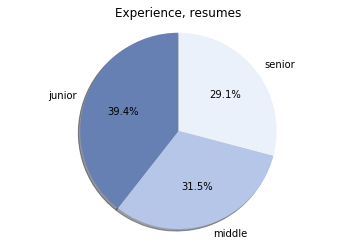

In [29]:
plt.figure() #второй анализ ноябрь-октябрь

labels = table_resumes['Qualification'].value_counts().index.tolist()
sizes = table_resumes['Qualification'].value_counts().values.tolist()
colors = ['#6780b3', '#b5c6e8', '#ebf1fb']
explode = (0, 0, 0)  # explode slice

plt.rcParams.update({'font.size': 10})
plt.pie(sizes, labels=labels, explode=explode, colors=colors, autopct='%1.1f%%', shadow=True, startangle=90)

plt.title('Experience, resumes')
plt.axis('equal')
plt.show()

In [79]:
resumes_need = []
num = 0
for name_area in areas_bot:
    area = areas_bot[name_area]
    print(str(round(num/len(areas_bot)*100, 2)) +  '%', end=' ')
    num += 1
    for abil in abilities_bot:
        for in_name in ['']:
            ability = abil + in_name
            for lev in levels_bot:
                level = levels_bot[lev]
                answer = [name_area, ability, level]
                
                helper = table_resumes[((table_resumes['Ability'] == ability) 
                        & (table_resumes['Area_id'] == area)
                        & (table_resumes['Qualification'] == level)
                        & (table_resumes['Salary'] > 10000))]['Salary']
                answer_min = helper.min()
                answer_max = helper.max()
                if helper.any():
                    answer_mean = int(round(helper.mean()/1000, 1)*1000)
                else:
                    answer_mean = helper.mean()
                answer_median = helper.median()
                answer_std = helper.std()
                if answer_min < 1000: #
                    answer_min = 1000 #
                answer.append(len(helper))
                answer.extend([answer_mean, answer_min, answer_max, answer_median, answer_std])
                resumes_need.append(answer)

0.0% 8.33% 16.67% 25.0% 33.33% 41.67% 50.0% 58.33% 66.67% 75.0% 83.33% 91.67% 

In [80]:
need_resumes = pd.DataFrame(resumes_need, columns = ['Name_area', 'Ability', 'Level', 'Amount',
                                                     'answer_mean', 'answer_min', 'answer_max',
                                                     'answer_median', 'answer_std'])

In [81]:
need_resumes.to_csv('need_resumes4.csv')
need_resumes.to_excel('need_resumes4.xlsx')

In [10]:
need_resumes = pd.read_csv('need_resumes4.csv', index_col = 'Unnamed: 0')

In [36]:
need_resumes.head()

,Name_area,Ability,Level,Amount,answer_mean,answer_min,answer_max,answer_median,answer_std
0,Москва,Java,junior,96,46700.0,12000.0,150000.0,40000.0,27873.272112
1,Москва,Java,middle,66,125100.0,20000.0,420000.0,100000.0,88749.317160
2,Москва,Java,senior,55,144800.0,30000.0,300000.0,130000.0,73225.701547
3,Москва,Javascript,junior,27,53600.0,18000.0,100000.0,45000.0,25090.832141
4,Москва,Javascript,middle,35,121700.0,30000.0,500000.0,100000.0,86545.582297


In [38]:
analysis_vacancies = pd.read_excel('./botGetIt/vacancies.xlsx')
columns = ['Name_area', 'Ability', 'Level', 'Amount', 'answer_mean', 'answer_min', 'answer_max','answer_median', 'answer_std']
for i in range(len(analysis_vacancies.columns)):
    analysis_vacancies = analysis_vacancies.rename(columns={analysis_vacancies.columns[i] : columns[i]})

In [39]:
analysis_vacancies.head()

,Name_area,Ability,Level,Amount,answer_mean,answer_min,answer_max,answer_median,answer_std
0,Москва,Java,junior,19,65000.0,15000.0,175000.0,60000.0,34641.016151
1,Москва,Java,middle,177,132700.0,20000.0,300000.0,130000.0,52887.195802
2,Москва,Java,senior,127,143000.0,50000.0,285000.0,140000.0,46097.506399
3,Москва,Javascript,junior,73,54800.0,20000.0,130000.0,55000.0,24102.613314
4,Москва,Javascript,middle,420,105500.0,20000.0,220000.0,100000.0,40502.576667


In [95]:
need_resumes['Name_area'].value_counts()

Новосибирск        45
Рязань             45
Нижний Новгород    45
Екатеринбург       45
Красноярск         45
Москва             45
Казань             45
Воронеж            45
Санкт-Петербург    45
Самара             45
Уфа                45
Томск              45
Name: Name_area, dtype: int64

## Табилца средних

In [12]:
analysis_vacancies = table_need

In [28]:
mean_list = []
num = 0
for name_area in areas_bot:
    area = areas_bot[name_area]
    print(str(round(num/len(areas_bot)*100, 2)) +  '%', end=' ')
    num += 1
    for abil in abilities_bot:
        for in_name in ['']:
            ability = abil + in_name
            for lev in sorted(list(levels_bot)):
                level = levels_bot[lev]
                two_mean_el = [name_area, ability, level]
                from_resumes = need_resumes[(need_resumes['Name_area'] == name_area)
                                           & (need_resumes['Level'] == level)
                                           & (need_resumes['Ability'] == ability)]
                from_vacancies = analysis_vacancies[(analysis_vacancies['Name_area'] == name_area)
                                           & (analysis_vacancies['Level'] == level)
                                           & (analysis_vacancies['Ability'] == ability)]
                vac_std = 0
                res_std = 0
                if from_vacancies['Amount'].all():
                    two_mean_el.append(int(from_vacancies['Amount']))
                else:
                    two_mean_el.append(None)
                if from_resumes['Amount'].all() and from_vacancies['Amount'].all():
                    two_mean_el.append( ( int(from_resumes['answer_mean']) + int(from_vacancies['answer_mean']) )/2 )
                    two_mean_el.append( ( int(from_resumes['answer_min']) + int(from_vacancies['answer_min']))/2)
                    two_mean_el.append( ( int(from_resumes['answer_max']) + int(from_vacancies['answer_max']) )/2)
                    if from_resumes['answer_std'].any():
                        res_std = int(from_resumes['answer_std']) / (int(from_resumes['Amount'])**0.5)
                    if from_vacancies['answer_std'].any():
                        vac_std = int(from_vacancies['answer_std']) / (int(from_vacancies['Amount'])**0.5)
                elif from_resumes['Amount'].all():
                    two_mean_el.append(int(from_resumes['answer_mean']))
                    two_mean_el.append(int(from_resumes['answer_min']))
                    two_mean_el.append(int(from_resumes['answer_max']))
                    if from_resumes['answer_std'].any():
                        res_std = int(from_resumes['answer_std'])/ (int(from_resumes['Amount'])**0.5)
                    vac_std = res_std
                    print(name_area, ability, level, 'vacancies')
                elif from_vacancies['Amount'].all():
                    two_mean_el.append(int(from_vacancies['answer_mean']))
                    two_mean_el.append(int(from_vacancies['answer_min']))
                    two_mean_el.append(int(from_vacancies['answer_max']))
                    if from_vacancies['answer_std'].any():
                        vac_std = int(from_vacancies['answer_std']) / (int(from_vacancies['Amount'])**0.5)
                    res_std = vac_std
                    print(name_area, ability, level, 'resumes')
                else:
                    two_mean_el.extend([None,None,None])
                    print(name_area, ability, level, 'together')
                two_mean_el.append(1.96*vac_std)
                two_mean_el.append(1.96*res_std)
                if two_mean_el[4]:
                    two_mean_el.append(1.96*(vac_std+res_std) / 2 / two_mean_el[4])
                    if two_mean_el[-1] > 0.25:
                        two_mean_el[-1] = 0.25
                    if 1.96*(vac_std+res_std) / 2 > 30000:
                        two_mean_el.append(two_mean_el[4] - 30000)
                        two_mean_el.append(two_mean_el[4] + 30000)
                    else:
                        two_mean_el.append(two_mean_el[4] - two_mean_el[-1]*two_mean_el[4])
                        two_mean_el.append(two_mean_el[4] + two_mean_el[-2]*two_mean_el[4])
                    two_mean_el[-1] = int(round(two_mean_el[-1]/10000, 1)*10000)
                    two_mean_el[-2] = int(round(two_mean_el[-2]/10000, 1)*10000)
                    two_mean_el[4] = int(round(two_mean_el[4]/10000, 1)*10000)
                else:
                    two_mean_el.extend([None, None, None])
                mean_list.append(two_mean_el)

0.0% Москва Postgres junior resumes
Москва Postgres middle resumes
Москва Postgres senior resumes
8.33% Санкт-Петербург Postgres junior resumes
Санкт-Петербург Postgres middle resumes
16.67% Казань Python junior vacancies
Казань IOS senior together
Казань Android senior resumes
Казань Go junior vacancies
Казань Go middle vacancies
Казань Go senior resumes
Казань Ruby junior together
Казань Ruby senior resumes
Казань SQL junior resumes
Казань Oracle junior together
Казань Postgres junior resumes
Казань Postgres middle resumes
25.0% Нижний Новгород IOS junior together
Нижний Новгород Go junior resumes
Нижний Новгород Go middle resumes
Нижний Новгород Go senior resumes
Нижний Новгород Ruby junior together
Нижний Новгород Ruby middle resumes
Нижний Новгород Ruby senior together
Нижний Новгород SQL junior resumes
Нижний Новгород SQL middle resumes
Нижний Новгород Oracle junior resumes
Нижний Новгород Postgres junior together
Нижний Новгород Postgres middle resumes
Нижний Новгород Postgres s

In [29]:
mean_table = pd.DataFrame(mean_list, columns = ['Name_area', 'Ability', 'Level', 'Amount',
                                                'answer_mean', 'answer_min', 'answer_max',
                                                'vac_std', 'res_std', 'pros_std'
                                                'std', 'low', 'high'])

In [30]:
mean_table.to_csv('mean_table_std.csv')
mean_table.to_excel('mean_table_std.xlsx')

In [69]:
#mean_table.to_csv('mean_table.csv')
#mean_table.to_excel('mean_table.xlsx')

In [15]:
mean_table = pd.read_csv('mean_table.csv')

## Рекомендации

In [40]:
table_vacancies141117.columns

Index(['Id', 'Area_id', 'Name', 'Salary_from', 'Salary_to', 'Salary_cur',
       'Data', 'Url', 'Experience', 'Company_name', 'Company_id',
       'Description', 'Employment', 'Schedule', 'Key_skills', 'Specialisation',
       'Arhived', 'qualification', 'Python', 'Python_name', 'C++', 'C++_name',
       'PHP', 'PHP_name', 'C#', 'C#_name', 'SQL', 'SQL_name', 'HTML',
       'HTML_name', 'CSS', 'CSS_name', 'Javascript', 'Javascript_name',
       'Swift', 'Swift_name', 'Ruby', 'Ruby_name', 'Postgres', 'Postgres_name',
       'IOS', 'IOS_name', 'Android', 'Android_name', 'Go', 'Go_name', 'Oracle',
       'Oracle_name'],
      dtype='object')

In [71]:
recommend_list = []
for main_ability in abilities_bot:
    for additional_ability in abilities_bot:
        if main_ability == additional_ability:
            continue
        amount_intersection = table_vacancies141117[(table_vacancies141117[main_ability] == 1)
                             & (table_vacancies141117[additional_ability] == 1)].shape[0]
        recommend_list.append([main_ability, additional_ability, amount_intersection])

In [73]:
recommend_table = pd.DataFrame(recommend_list, columns = ['First', 'Second', 'Intersection'])

In [70]:
big_recommend_table = recommend_table
big_recommend_table.to_csv('big_recommend_table.csv')

In [83]:
recommend_table.to_csv('recommend_table.csv')

In [92]:
recommend_dict2 = {'Android': ['Java', 'SQL'],
 'C#': ['SQL'],
 'C++': ['SQL', 'C#'],
 'CSS': ['HTML', 'Javascript'],
 'Go': ['SQL'],
 'HTML': ['CSS', 'Javascript'],
 'IOS': ['SQL', 'Swift'],
 'Java': ['SQL', 'Javascript', 'HTML', 'Python'],
 'Javascript': ['HTML', 'CSS', 'SQL', 'PHP'],
 'Oracle': ['SQL'],
 'PHP': ['SQL', 'Javascript', 'HTML', 'CSS'],
 'Postgres': ['SQL'],
 'Python': ['SQL', 'Javascript', 'Postgres'],
 'Ruby': ['SQL', 'Python'],
 'SQL': ['Javascript', 'PHP', 'HTML', 'CSS', 'Postgres']}

In [88]:
recommend_dict = {}
for main_ability in abilities_bot:
    print(main_ability)
    recommend_dict[main_ability] = []
    while True:
        text = input()
        if text not in abilities_bot:
            break
        recommend_dict[main_ability].append(text)

Java
SQL
Javascript
HTML
Python

Javascript
HTML
CSS
SQL
PHP

Python
SQL
Javascript
Postgres

C++
SQL
C#

C#
SQL

IOS
SQL

Android
Java
SQL

PHP
SQL
Javascript
HTML
CSS

Go
SQL

Ruby
SQL
Python

SQL
Javascript
PHP
HTML
CSS
Postgres

Oracle
SQL

Postgres
SQL

HTML
CSS
Javascript

CSS
HTML
Javascript



In [84]:
for main_ability in abilities_bot:
    print(recommend_table[recommend_table['First'] == main_ability].sort_values(by='Intersection', ascending=False).head())
    

   First      Second  Intersection
9   Java         SQL           672
0   Java  Javascript           420
12  Java        HTML           287
1   Java      Python           225
11  Java    Postgres           220
         First Second  Intersection
26  Javascript   HTML          2033
27  Javascript    CSS          1935
23  Javascript    SQL          1814
20  Javascript    PHP          1386
17  Javascript     C#           443
     First      Second  Intersection
37  Python         SQL           493
29  Python  Javascript           294
39  Python    Postgres           241
28  Python        Java           225
30  Python         C++           213
   First      Second  Intersection
51   C++         SQL           268
45   C++          C#           224
44   C++      Python           213
42   C++        Java           187
43   C++  Javascript           142
   First      Second  Intersection
65    C#         SQL           680
57    C#  Javascript           443
68    C#        HTML           303
69

In [41]:
abilities_bot

['Java',
 'Javascript',
 'Python',
 'C++',
 'C#',
 'IOS',
 'Android',
 'PHP',
 'Go',
 'Ruby',
 'SQL',
 'Oracle',
 'Postgres',
 'HTML',
 'CSS']

# Не нужно

In [379]:
# Парсинг сайта

In [ ]:
r = open("some.html")
r.write(page_text)
r.close()

In [380]:
from bs4 import BeautifulSoup

In [381]:
soup = BeautifulSoup(page_text, 'html.parser')

In [ ]:
print(soup.prettify())

# Первый заход

In [42]:
Python_on_name = table_vacancies['Name'].apply(find_word_name)

In [93]:
Cplusplus = table_vacancies['Description'].apply(find_word)

In [76]:
PHP = table_vacancies['Description'].apply(find_word)

In [67]:
Cresh = table_vacancies['Description'].apply(find_word)

In [89]:
SQL = table_vacancies['Description'].apply(find_word)

In [95]:
HTML = table_vacancies['Description'].apply(find_word)

In [103]:
CSS = table_vacancies['Description'].apply(find_word)

In [107]:
Javascript = table_vacancies['Description'].apply(find_word)

In [111]:
Swift = table_vacancies['Description'].apply(find_word)

In [123]:
Ruby = table_vacancies['Description'].apply(find_word)

In [134]:
Java = table_vacancies['Description'].apply(hard_find_word)

In [137]:
table_vacancies['Python'] = Python_on
table_vacancies['C/C++'] = Cplusplus
table_vacancies['PHP'] = PHP
table_vacancies['C#'] = Cresh
table_vacancies['SQL'] = SQL
table_vacancies['HTML'] = HTML
table_vacancies['CSS'] = CSS
table_vacancies['Javascript'] = Javascript
table_vacancies['Swift'] = Swift
table_vacancies['Ruby'] = Ruby
table_vacancies['Java'] = Java

In [79]:
#Москва, Санкт-Петербург, Татарстан, Новосибирская, Пермский, Свердловская, Краснодарский, Башкортостан, Нижеородская
#Ростовская,Самарская, Красноярский, Челябинская, Воронежская
bot_areas = [1, 2, 1624, 1202, 2012, 1261, 1438, 1347, 1679, 1530, 1586, 1146, 1384, 1844]

In [82]:
bot_skills = ['Python', 'C/C++', 'PHP', 'C#', 'SQL', 'HTML', 'CSS', 'Javascript', 'Swift', 'Ruby']

In [84]:
bot_qualifications = ['junior', 'middle', 'senior']

In [ ]:
answers = [] #Area_id, Area_name, Qualification, Skill, Minimum, Maximum, Average, Amount 
for bot_area in bot_areas:
    for bot_skill in bot_skills:
        for bot_qual in bot_qualifications: 
            answers.append([bot_area, small_table_area[small_table_area['Area_id'] == bot_area]['Name']])
            answers[-1].append(bot_qual)
            answers[-1].append(bot_skill)
            answers[-1].append()


In [132]:
s = 'java-super' 
prog = re.compile('[А-Яа-яA-Za-z\-]+')
l1 = prog.findall(s.lower())
d1 = nltk.FreqDist(l1)
if bool(d1['java']):
    print('woho')

['java-super']


## Анализ таблицы

In [58]:
s = ''
for i in table_vacancies['Name']:
    s += i.replace('&quot;', ' ') + ' '

In [52]:
prog = re.compile('[А-Яа-яA-Za-z\-]+')
l1 = prog.findall(s.lower())
d1 = nltk.FreqDist(l1)
print(d1.most_common()[0:20])

[('е', 68373), ('о', 64566), ('и', 60604), ('а', 55455), ('н', 48457), ('р', 44742), ('т', 38175), ('в', 31240), ('к', 27108), ('п', 26464), ('с', 25345), ('л', 21382), ('д', 18826), ('s', 18508), ('м', 17228), ('a', 15408), ('e', 14150), ('t', 13288), ('o', 11666), ('r', 11640)]


In [339]:
table_vacancies['Experience'].value_counts()

between1And3    14210
noExperience     6513
between3And6     5624
moreThan6         507
Name: Experience, dtype: int64